## Описание проекта

Перед открытием своего заведения нужно подготовить исследование рынка. У нас есть открытые данные о заведениях общественного питания в Москве.

### Описание данных
Таблица rest_data:
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

1. [Открытие данных](#open)
2. [Предобработка данных](#preprocessing)

### Открытие данных. <a id="open"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.to_csv('rest_data', sep=',', index_label =False)

In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<a id="preprocessing"></a>
### Предобработка данных

Визуальный просмотр файла данных в Excel показал, что очень много ситуаций, когда названия сетевых заведений пишутся по-разному - МАКДОНАЛДС, Макдоналдс, Кафе "Макдоналдс" и т.д. То есть при анализе мы получим результат, что это все разные сети, а не одна и та же. С эти надо побороться.

In [5]:
# для начала переведем все названия в нижний регистр
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [6]:
def rename(name):
        """
        Ищет в названиях ресторанов слова: 'макдоналдс',  'бургер кинг' и т.д. если в названии содержится это слово, 
        то оно будет новым названием ресторана, во всех остальных случаях - оставляет старое название
        """
        new_name = name
        for x in {'макдоналдс','бургер кинг','шоколадница', 'му-му', 'kfc'}:
            if x in name:
                new_name = x
        return new_name   
    
rest_data['name_processed'] = rest_data['object_name'].apply(rename)

In [7]:
rest_data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

In [8]:
# есть заведения, где указана нулевая вместимость. скорее всего, это означает, что эти данные просто не внесли 
# при составлении таблицы. узнаем - сколько таких ресторанов.
rest_data[rest_data['number']==0].count()

id                1621
object_name       1621
chain             1621
object_type       1621
address           1621
number            1621
name_processed    1621
dtype: int64

Это около 10% всего массива. Слишком много, чтобы просто их удалить. Это ведь реально существующие кафе и рестораны и нужно их учитывать при подсчете распределения заведений по типам или по районам.

С другой стороны, если их оставить, то они повлияют на значения средней вместимости заведений. Думаю, что следует поступить так - на этапе подсчета вместимости использовать версию датафрейма, где "нулевые" заведения будут удалены, для ответов на остальные вопросы использовать полный датафрейм.

Большая часть таких мест - различные ларьки с шавермой, теремки, кофе с собой. Но есть и маки, и kfc, и бургер-кинг. По какой-то определенной категории их не выделить, там полная чехарда  - и предприятие быстрого обслуживания, и буфет, и кафе, и столовая, и ресторан.
    

In [9]:
# формируем датафрейм, откуда удалены данные с нулевой вместимостью
rest_data_wht_empty = rest_data.query('number>0').copy().reset_index()
rest_data_wht_empty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13745 entries, 0 to 13744
Data columns (total 8 columns):
index             13745 non-null int64
id                13745 non-null int64
object_name       13745 non-null object
chain             13745 non-null object
object_type       13745 non-null object
address           13745 non-null object
number            13745 non-null int64
name_processed    13745 non-null object
dtypes: int64(3), object(5)
memory usage: 859.2+ KB


In [11]:
rest_data[['object_name', 'chain', 'object_type', 'address']].duplicated().sum()

183

Имеются дубликаты. Количество незначительное относительно всего датасета. Можно удалять.
    Типы столбцов соответствуют содержащимся в них данным.

In [12]:
rest_data = rest_data.drop_duplicates(['object_name', 'chain', 'object_type', 'address'])

In [13]:
rest_data[['object_name', 'chain', 'object_type', 'address']].duplicated().sum()

0

### Анализ данных
- [Исследовать соотношение видов объектов общественного питания по количеству. Построить график](#types)
- [Исследовать соотношение сетевых и несетевых заведений по количеству. Построить график.](#quantity_chain)
- [Для какого вида объекта общественного питания характерно сетевое распространение?](#chain_types)
- [Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#chain_parameters)
- [Для каждого вида объекта общественного питания описать среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Построить графики.](#type_parameters)
- [Выделить в отдельный столбец информацию об улице из столбца address.](#street)
- [Построить график топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?](#top_street)
- [Найти число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?](#single_rest)
- [Проанализируйте распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?](#top_street_distribution)
#### Сформулировать общий вывод и дать рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Дать комментарий о возможность развития сети.

<a id="types"></a>
#### Исследовать соотношение видов объектов общественного питания по количеству. Построить график.

In [14]:
rest_quantity = rest_data.groupby('object_type', as_index=False)[['id']].count().sort_values(by='id')
rest_quantity

,object_type,id
5,магазин (отдел кулинарии),272
2,закусочная,347
4,кафетерий,393
1,буфет,570
0,бар,853
6,предприятие быстрого обслуживания,1890
7,ресторан,2275
8,столовая,2575
3,кафе,6008


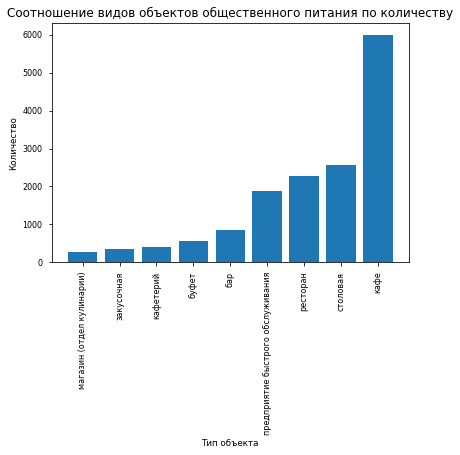

In [15]:
with plt.style.context('seaborn-paper'):
    plt.bar(rest_quantity['object_type'], rest_quantity['id'])
plt.xlabel('Тип объекта')
plt.ylabel('Количество')
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.xticks(rotation=90)     
plt.show()

Кафе лидируют с огромным отрывом!

<a id="quantity_chain"></a>
### <font color="blue"> Исследовать соотношение сетевых и несетевых заведений по количеству. Построить график.

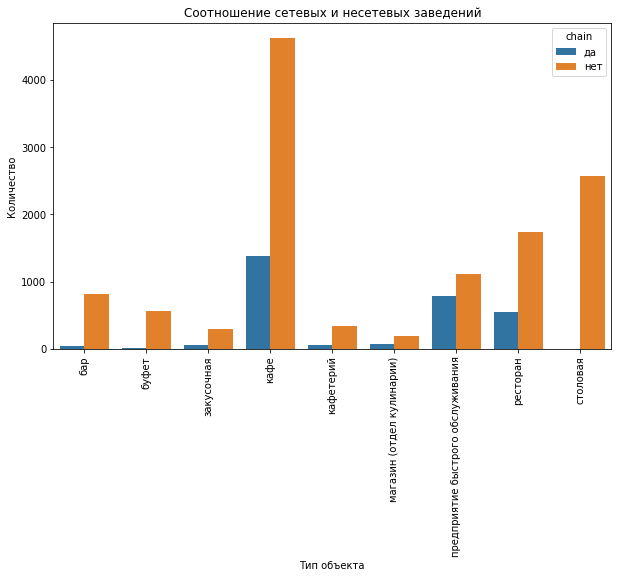

In [16]:
quantity_chain = rest_data.groupby(['object_type', 'chain'], as_index=False).agg({'id':'count'}).rename(columns={'id': 'rest_quant'})
quantity_chain.rename(columns={'id': 'rest_quant'})                                                                                 
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Соотношение сетевых и несетевых заведений')
ax = sns.barplot(x="object_type", y="rest_quant", hue='chain', data=quantity_chain)
ax.set(xlabel='Тип объекта', ylabel='Количество')
plt.show()

In [17]:
quantity_chain

,object_type,chain,rest_quant
0,бар,да,37
1,бар,нет,816
2,буфет,да,11
3,буфет,нет,559
4,закусочная,да,56
5,закусочная,нет,291
6,кафе,да,1387
7,кафе,нет,4621
8,кафетерий,да,51
9,кафетерий,нет,342


<a id="chain_types"></a>
### Для какого вида объекта общественного питания характерно сетевое распространение?
##### Неудивительно, но самая большая доля сетевых точек у предприятий быстрого питания - более 40%, затем плотно идет группа в полосатых купальниках, где доля сетевых заведений около четверти - кафе, рестораны и кулинарии.

<a id="chain_parameters"></a>
### <font color="blue"> Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [18]:
# Речь пошла о вместимости, будем пользоваться датафреймом, где удалены заведения с нулевой вместимостью.
# делаем срез по сетевым заведениям
chains_data = rest_data_wht_empty.query('chain=="да"')
chains_data.head(3)

,index,id,object_name,chain,object_type,address,number,name_processed
3,3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория
6,6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,брусника
13,13,22579,алло пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32,алло пицца


In [19]:
# группируем по названиям ресторанов, переименовываем столбец в название сети
chains_by_rest = chains_data.groupby(['name_processed'], as_index=False).agg({'object_type':'count', 'number':'mean'})
chains_by_rest.columns = ['chain_name', 'quantity', 'mean_capacity']
chains_by_rest.head(3)

,chain_name,quantity,mean_capacity
0,beverly hills diner,1,88.0
1,bierloga,1,75.0
2,black & white,1,40.0


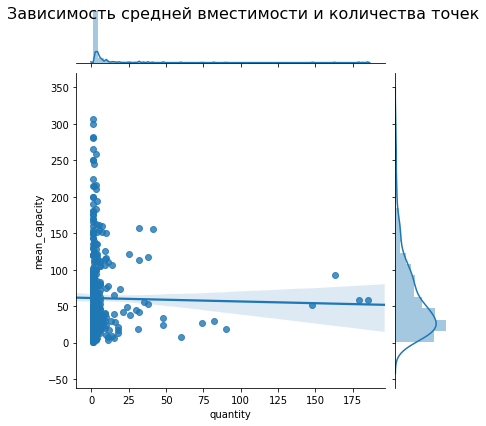

In [20]:
g = sns.jointplot(x="quantity", y="mean_capacity", data=chains_by_rest, kind='reg');
g.fig.suptitle('Зависимость средней вместимости и количества точек', fontsize=16);

In [21]:
chains_by_rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 0 to 521
Data columns (total 3 columns):
chain_name       522 non-null object
quantity         522 non-null int64
mean_capacity    522 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 16.3+ KB


In [22]:
chains_by_rest[chains_by_rest['quantity']==1].nunique()

chain_name       306
quantity           1
mean_capacity     85
dtype: int64

In [23]:
chains_by_rest[chains_by_rest['quantity']==1]['mean_capacity'].describe()

count    306.000000
mean      59.797386
std       56.091536
min        1.000000
25%       20.000000
50%       45.000000
75%       80.000000
max      306.000000
Name: mean_capacity, dtype: float64

In [24]:
np.percentile(chains_by_rest[chains_by_rest['quantity']==1]['mean_capacity'],[90, 95, 99])

array([132.5 , 173.75, 279.3 ])

Вот так-так! 59% "сетей" состоят из всего одного заведения! Средняя вместимость таких заведений 60 человек, медиана равна 45 местам.

In [25]:
#количество заведенеий в сети, если сеть состоит как минимум из 2х точек
chains_by_rest[chains_by_rest['quantity']>1]['quantity'].describe()

count    216.000000
mean      11.083333
std       25.212446
min        2.000000
25%        2.000000
50%        4.000000
75%        7.250000
max      185.000000
Name: quantity, dtype: float64

In [26]:
np.percentile(chains_by_rest[chains_by_rest['quantity']>1]['quantity'],[90, 95, 99])

array([ 22.5 ,  38.75, 160.75])

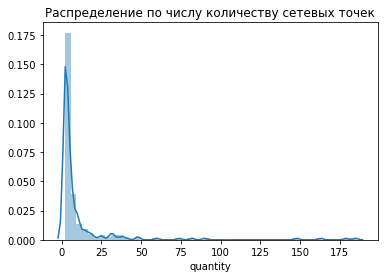

In [27]:
x = chains_by_rest[chains_by_rest['quantity']>1]['quantity']
sns.distplot(x).set_title('Распределение по числу количеству сетевых точек');


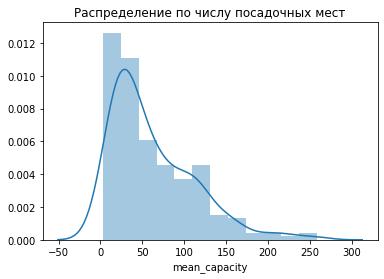

In [28]:
x = chains_by_rest[chains_by_rest['quantity']>1]['mean_capacity']
sns.distplot(x).set_title('Распределение по числу посадочных мест');

Среднее число точек в сети - 11, а медиана - всего 4. Такая разница объясняется тем, что у нас из 216 сетевых заведений, 185 принадлежат одной сети. Что же это за сеть? Впрочем, я догадываюсь...

In [29]:
chains_by_rest[chains_by_rest['quantity']==chains_by_rest['quantity'].max()]

,chain_name,quantity,mean_capacity
510,шоколадница,185,57.648649


Шоколадница, а вовсе и не Макдональдс!

In [30]:
chains_by_rest[chains_by_rest['quantity']>1]['mean_capacity'].describe()

count    216.000000
mean      62.250046
std       49.799173
min        3.272727
25%       23.479167
50%       45.333333
75%       93.083333
max      258.666667
Name: mean_capacity, dtype: float64

Для сетей здорового человека (где есть хотя бы 2 ресторана) количество посадочных мест практически не отличается - среднее 62, медиана 45.

In [31]:
chains_by_rest[chains_by_rest['quantity']>1]['mean_capacity'].describe()

count    216.000000
mean      62.250046
std       49.799173
min        3.272727
25%       23.479167
50%       45.333333
75%       93.083333
max      258.666667
Name: mean_capacity, dtype: float64

#### Очень много сетей, где 1-2-3-4 объекта, таких половина. Одна сеть очень большая - 185 ресторанов,  еще несколько  сетей из пяти- десяти ресторанов. В 90% сетей входит не больше 22 ресторанов. Средняя вместимость 62 человека, медианная - 45. Это примерно 12 столиков.

<a id="type_parameters"></a>
### <font color="blue">Для каждого вида объекта общественного питания описать среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Построить графики.

In [32]:
numbers_by_type = rest_data_wht_empty.groupby('object_type', as_index=False)[['number']].mean().sort_values(by='number')
numbers_by_type

,object_type,number
5,магазин (отдел кулинарии),11.921875
4,кафетерий,12.740351
2,закусочная,16.017544
6,предприятие быстрого обслуживания,32.421657
3,кафе,41.842805
0,бар,44.964976
1,буфет,57.854932
7,ресторан,98.779464
8,столовая,131.210280


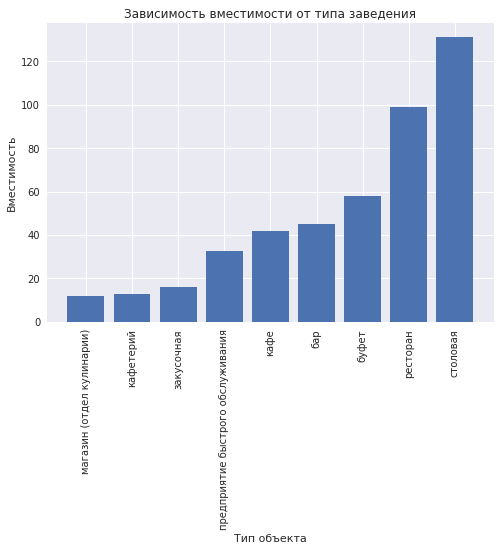

In [33]:
with plt.style.context('seaborn'):
    plt.bar(numbers_by_type['object_type'], numbers_by_type['number'])
plt.xticks(rotation=90)
plt.xlabel('Тип объекта')
plt.ylabel('Вместимость')
plt.title('Зависимость вместимости от типа заведения')
plt.show()

#### Больше всего посадочных мест в столовых - на треть  больше даже чем в ресторанах!!

<a id="street"></a>
### <font color="blue"> Выделить в отдельный столбец информацию об улице из столбца address. 

In [34]:
rest_data['street'] = rest_data['address'].str.extract(',\s([А-я\s]+),')[0]  
rest_data.head(3)

,id,object_name,chain,object_type,address,number,name_processed,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе «академия»,Абельмановская улица


<a id="top_street"></a>
### <font color="blue"> Построить график топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?

In [35]:
top_streets = rest_data.groupby('street', as_index=False).agg({'id':'count'}).rename(columns={'id': 'rest_quant'}).sort_values(by='rest_quant', ascending=False)
top_streets.head(12)

,street,rest_quant
1026,город Зеленоград,230
1089,проспект Мира,196
715,Профсоюзная улица,180
422,Ленинградский проспект,170
701,Пресненская набережная,165
154,Варшавское шоссе,159
425,Ленинский проспект,147
1065,поселение Сосенское,137
1086,проспект Вернадского,126
413,Кутузовский проспект,114


####  <font color="green"> Для определения района города по названию улицы воспользуемся таблицей с данными Мосгаза.

In [36]:
streets_list = pd.read_csv('http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv').rename(columns={'streetname': 'street'})

streets_list.head(3)

,street,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район


In [37]:
rest_district = top_streets.merge(streets_list, how='left', on='street')[['street', 'rest_quant', 'okrug', 'area']]
rest_district.head(52)

,street,rest_quant,okrug,area
0,город Зеленоград,230,Зеленоград,Район Крюково
1,город Зеленоград,230,Зеленоград,Район Матушкино-Савелки
2,город Зеленоград,230,Зеленоград,Панфиловский район
3,проспект Мира,196,СВАО,Алексеевский район
4,проспект Мира,196,СВАО,Ярославский Район
5,проспект Мира,196,СВАО,Район Марьина роща
6,проспект Мира,196,СВАО,Останкинский район
7,проспект Мира,196,СВАО,Район Ростокино
8,проспект Мира,196,СВАО,Район Свиблово
9,проспект Мира,196,ЦАО,Мещанский район


Зеленоград и поселение Сосенское попали в столбец street из-за того, что в адресах городских поселений есть дополнительное поле. Но, так как нас интересуют улицы с наибольшим числом заведений, то уютным Зеленоградом и прелестным Сосенским можно пожертвовать. Удалим их из  таблицы.

In [38]:
rest_district = rest_district.drop(rest_district[(rest_district.street=='город Зеленоград') | (rest_district.street=='поселение Сосенское')].index)
rest_district.head(48)

,street,rest_quant,okrug,area
3,проспект Мира,196,СВАО,Алексеевский район
4,проспект Мира,196,СВАО,Ярославский Район
5,проспект Мира,196,СВАО,Район Марьина роща
6,проспект Мира,196,СВАО,Останкинский район
7,проспект Мира,196,СВАО,Район Ростокино
8,проспект Мира,196,СВАО,Район Свиблово
9,проспект Мира,196,ЦАО,Мещанский район
10,Профсоюзная улица,180,ЮЗАО,Академический район
11,Профсоюзная улица,180,ЮЗАО,Район Черемушки
12,Профсоюзная улица,180,ЮЗАО,Район Ясенево


In [39]:
xxx = rest_district.groupby(['street', 'okrug'])[['street', 'okrug']]
xxx.head()

,street,okrug
3,проспект Мира,СВАО
4,проспект Мира,СВАО
5,проспект Мира,СВАО
6,проспект Мира,СВАО
7,проспект Мира,СВАО
...,...,...
1947,Мишина улица,САО
1948,Балтийская улица,САО
1949,Балтийская улица,САО
1950,Мрузовский переулок,ЦАО


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


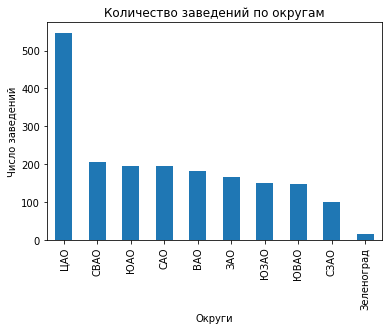

In [53]:
ax = pd.Series(rest_district['okrug']).value_counts().plot('bar', title='Количество заведений по округам')
ax.set_xlabel("Округи")
ax.set_ylabel("Число заведений");

Центральный округ лидирует по количеству точек с огромным отрывом. Отдыхать надо в центре! В том числе и с роботами!

Как и следовало ожидать, в список попали самые большие по протяженности московские улицы. И поэтому есть сложности с определением района Москвы, где эти улицы находятся. Они проходят через несколько районов, а некоторые - даже через несколько городских округов. Например Ленинский находится в Центральном, Южном, Юго-Западном и Западном округах, проспект Мира - в Центальном и Северо-Восточном, Вернадского - в ЗАО и ЮЗАО. Но если учитывать все округа, то получается, что из 12 московских округов топ-10 улиц с наибольшим количеством предприятий общественного питания расположены в 6ти из них. При этом в  Южном округе проходят сразу 4 таких улицы, в Центральном, Западном и Юго-Западном - по 3, в Северном и Северо-Восточном - 1.

<a id="single_rest"></a>
### <font color="blue">Найти число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?

In [41]:
singl_rest_street = top_streets[top_streets['rest_quant'] == 1].reset_index()
singl_rest_street.head(3)

,index,street,rest_quant
0,1289,улица Кутузова,1
1,1491,улица Шеногина,1
2,139,Брошевский переулок,1


In [42]:
singl_rest_street.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 3 columns):
index         396 non-null int64
street        396 non-null object
rest_quant    396 non-null int64
dtypes: int64(2), object(1)
memory usage: 9.4+ KB


#### Таких улиц слишком 396. Для определения района города по названию улицы также воспользуемся таблицей с данными Мосгаза. 

In [43]:
singl_rest_street_district = singl_rest_street.merge(streets_list, how='left', on='street')[['street', 'okrug', 'area']]
singl_rest_street_district.head(3)

,street,okrug,area
0,улица Кутузова,ЗАО,Можайский Район
1,улица Шеногина,СЗАО,Район Хорошево-Мневники
2,Брошевский переулок,ЦАО,Таганский район


In [44]:
# посмотрим распределение по округам 
singl_rest_street_district.groupby('okrug', as_index=False)[['street']].count().sort_values(by='street', ascending=False)

,okrug,street
6,ЦАО,151
4,СВАО,47
3,САО,41
0,ВАО,39
8,ЮВАО,39
1,ЗАО,32
5,СЗАО,24
9,ЮЗАО,24
7,ЮАО,21
2,Зеленоград,1


##### Больше всего таких улиц - 151 (38%) расположены в центральном округе! По более переферийным округам они размазаны по 20-40 штук, ничто по сравнению с центром. На московских изогнутых улицах мне в кафе бы откушать вок!

###### Посмотрим теперь как они распределены по районам внутри центрального округа.

In [45]:
singl_rest_street_district_cao = singl_rest_street_district[singl_rest_street_district['okrug']=='ЦАО']
singl_rest_street_area = singl_rest_street_district_cao.groupby('area', as_index=False)[['street']].count().sort_values(by='street', ascending=False)

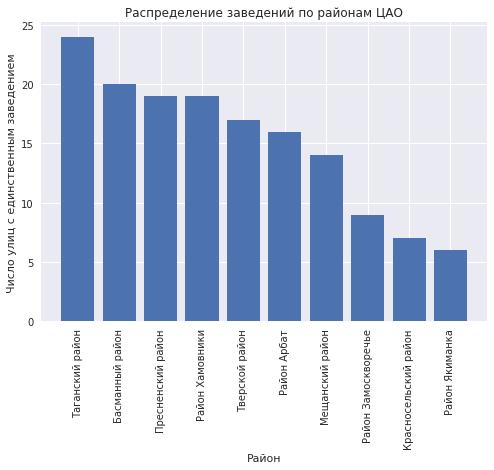

In [46]:
with plt.style.context('seaborn'):
    plt.bar(singl_rest_street_area['area'], singl_rest_street_area['street'])
plt.xticks(rotation=90)
plt.xlabel('Район')
plt.ylabel('Число улиц с единственным заведением')
plt.title('Распределение заведений по районам ЦАО')
plt.show()

##### Таганка! Зачем сгубила ты меня!

<a id="top_street_distribution"></a>
### <font color="blue">Проанализировать распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [47]:
rest_data_wht_empty.head()
rest_data_wht_empty['street'] = rest_data_wht_empty['address'].str.extract(',\s([А-я\s]+),')[0]  
rest_data_wht_empty.head()

,index,id,object_name,chain,object_type,address,number,name_processed,street
0,0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе «академия»,Абельмановская улица
3,3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе «вишневая метель»,Абрамцевская улица


In [48]:
# опять вопрос про вместимость, значит опять призываем датасет с ненулевой вместимостью
top_streets_wht_empty = rest_data_wht_empty.groupby('street', as_index=False).agg({'id':'count','number':'mean', 'object_type':'first'}).rename(columns={'id': 'rest_quant'}).sort_values(by='rest_quant', ascending=False)
top_streets_wht_empty.head(20)

,street,rest_quant,number,object_type
1013,город Зеленоград,225,75.777778,столовая
1073,проспект Мира,192,66.614583,кафе
419,Ленинградский проспект,158,57.025316,кафе
696,Пресненская набережная,156,49.076923,ресторан
709,Профсоюзная улица,142,59.485915,столовая
154,Варшавское шоссе,140,60.807143,кафе
422,Ленинский проспект,137,68.102190,ресторан
1070,проспект Вернадского,130,68.000000,кафе
1052,поселение Сосенское,110,28.290909,кафе
410,Кутузовский проспект,98,98.948980,ресторан


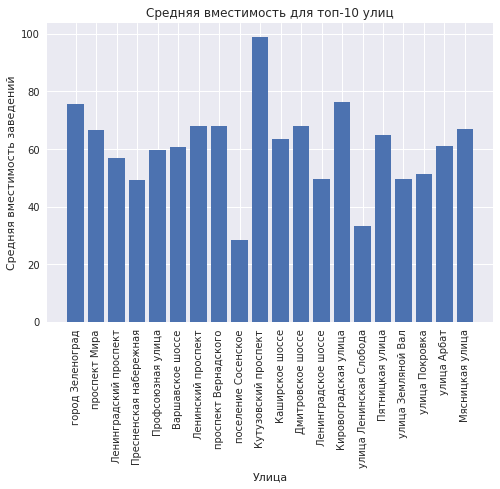

In [52]:

with plt.style.context('seaborn'):
    plt.bar(top_streets_wht_empty.head(20)['street'], top_streets_wht_empty.head(20)['number'])
plt.xticks(rotation=90)
plt.xlabel('Улица')
plt.ylabel('Средняя вместимость заведений')
plt.title('Средняя вместимость для топ-10 улиц')
plt.show()

Заметно выбиваются в меньшую сторону посление Сосенское (договорились не принимать их в расчет с Зеленоградом, так как это не улицы) и Ленинская слобода - относительно небольшая улица. И сразу там средняя вместимость 35 мест против 60-70 на больших проспектах.

In [50]:
top_streets_wht_empty.head(20)['number'].mean()

60.846056033404054

In [51]:
top_streets_wht_empty[(top_streets_wht_empty['rest_quant']==1) & (top_streets_wht_empty['object_type']=='кафе')]['number'].mean()

42.56910569105691

Средняя вместимость для улиц с большим количеством объектов общественного питания - 60. В центральных районах заведениях примерно в полтора раза меньше по вместимости, чем на больших магистралях - больше. Примерно такая же вместимость характерна для сетевых ресторанов. Для не входящих в сети она чуть больше - 68. В общем, похоже, что 60-70 мест это оптимальное число.

#### ВыводЫ: 
1. Если смотреть на вместимость заведений в зависимости от типа, то самые большие - столовые (150), рестораны (100), затем бары, буфеты и кафе (40-60 мест). Но так как наша концепция основана на официантах, то выбор стоит между рестораном и кафе. Затевать ресторан - затея намного более сложная, дорогостоящая и рискованная. Поэтому для первого заведения я рекомендую формат кафе. Десяток столиков на 40-50 человек -то что надо для начала.
2. С форматом опередились, теперь нужно выбрать район. С одной стороны есть большие магистрали с десятками (и даже сотнями) заведений, с другой - маленькие улицы в центре с 1-2 ресторанами. Но если на улице 100 ресторанов, то выше и конкуренция. Да и из-за особенностей архитектуры зданий на таких магистралях (сталинская или более поздняя постройка), вместимость заведений там выше (70-80 против 30-40 в центре). Вряд ли кто-то поедет специально в кафе в условное Чертаново, тогда как в центре - конечно да. Туда могут зайти как офисные работники после трудового дня, так и туристы передохнуть после дня в Пушкинском музее. Мой выбор - небольшая улица в центре.

## Общий вывод

Нужный нам формат - это кафе. Нам нужны официанты, роль которых будут исполнять роботы, поэтому варианты с баром, буфетом, фастфудом нам не подходят. А ресторан имеет уже гораздо бОльшую вместимость, выше требования к кухне, к меню и т.д.

Кафе имеет оригинальный формат, свою "фишку" - роботов, имеет все шансы привлекать не только москвичей, но и стать туристической достопримечательностью, поэтому целесообразно будет разместить его в одном из центральных районов, на одной из небольших улиц. Средняя вместимость таких заведений - около 40 мест.

При условии успеха первого заведения следует рассмотреть воозможность открытия второго, в другом районе. 
Помимо того, что роботы-официанты это аттракцион, возможно они окажутся экономически выгоднее людей-официантов. При высоких начальных вложениях, в дальнейшем они будут обходиться дешевле. Но это уже тема другого исследования.

Презентация: https://yadi.sk/i/HxWh0a-QUcKEuQ